In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

### Network Analysis

In [111]:

# Read monthly trade data
df_trade = pd.read_csv('data/processed/monthly_trade_data.csv')

# Convert 'Period' to datetime format
df_trade['Period'] = pd.to_datetime(df_trade['Period'])

# Display the DataFrame
print(df_trade.head())
print(df_trade.info())


      Period ReporterISO PartnerISO  PrimaryValue
0 2015-01-01         DZA        USA      2628.566
1 2015-01-01         AGO        FRA       495.050
2 2015-01-01         AGO        NAM      2426.630
3 2015-01-01         AGO        USA        60.910
4 2015-01-01         AZE        NLD      3215.760
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460996 entries, 0 to 460995
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Period        460996 non-null  datetime64[ns]
 1   ReporterISO   460996 non-null  object        
 2   PartnerISO    460996 non-null  object        
 3   PrimaryValue  460996 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 14.1+ MB
None


Identify important nodes

In [112]:

# Function to create and compute centrality for a specific period
def create_and_compute_centrality_for_period(df, period):
    # Filter data for the specific period
    period_data = df[df['Period'] == period]

    # Create a graph
    G = nx.Graph()

    # Add nodes and edges with trade values
    for _, row in period_data.iterrows():
        G.add_edge(row['ReporterISO'], row['PartnerISO'], weight=row['PrimaryValue'])

    # Calculate centrality measures
    closeness_centrality = nx.closeness_centrality(G, distance='weight')

    return G, closeness_centrality

# Function to plot the network with centrality measures
def plot_network_with_centrality(G, centrality, title):
    fig, ax = plt.subplots(figsize=(10, 7), nrows=1, ncols=2, gridspec_kw={'width_ratios': [10, 0.5]})

    # Normalize centrality values for coloring
    centrality_values = np.array(list(centrality.values()))
    norm = plt.Normalize(centrality_values.min(), centrality_values.max())
    node_colors = [cm.viridis(norm(centrality[node])) for node in G.nodes()]
    
    # Define node positions
    pos = {}
    circPos = nx.shell_layout(G)
    for node, coords in circPos.items():
        pos[node] = (coords[0] + 0.01, coords[1] - 0.05)

    # Draw the network
    nx.draw(G, pos, ax=ax[0], node_size=50, edge_color='gray', with_labels=False, node_color=node_colors, cmap=cm.viridis)
    
    # Create a colorbar with a separate axis (ax)
    sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
    sm.set_array([])
    cbar_ax = ax[1]  # Use the second axis for the colorbar
    plt.colorbar(sm, cax=cbar_ax, label='Centrality')

    # Set title for the network plot
    ax[0].set_title(title)
    plt.show()


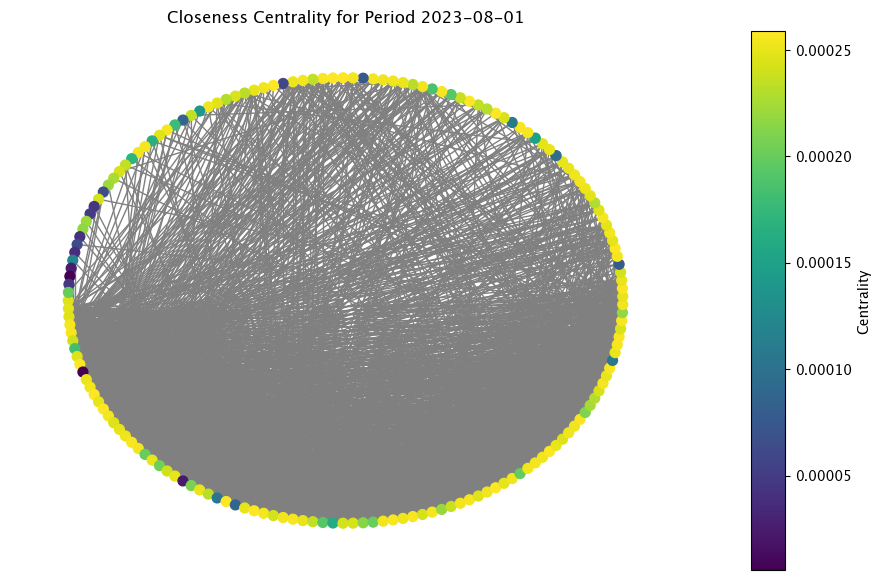

In [113]:
# Apply to chosen periods
chosen_period = ['2023-08-01']

for period in chosen_period:
    # Create and compute centrality for the period
    G, closeness_centrality = create_and_compute_centrality_for_period(df_trade, period)

    # Plot the network with closeness centrality
    plot_network_with_centrality(G, closeness_centrality, f'Closeness Centrality for Period {period}')

In [114]:

# Function to identify important and not important nodes
def identify_node_importance_for_period(df, period):
    """
    Identifies important and not important nodes in a trade network for a specific period based on closeness centrality.

    Parameters:
    df (DataFrame): The trade data DataFrame containing 'Period', 'ReporterISO', 'PartnerISO', and 'PrimaryValue'.
    period (str): The period to filter the data for, in the format 'YYYY-MM'.

    Returns:
    G (Graph): The NetworkX graph created for the specified period.
    nodes_notimp (list): List of nodes with closeness centrality below the 25th percentile.
    nodes_imp (list): List of nodes with closeness centrality above the 75th percentile.
    """
    # Filter data for the specific period
    period_data = df[df['Period'] == period]

    # Create a graph
    G = nx.Graph()

    # Add nodes and edges with trade values
    for _, row in period_data.iterrows():
        G.add_edge(row['ReporterISO'], row['PartnerISO'], weight=row['PrimaryValue'])

    # Compute closeness centrality
    closeness_centrality = nx.closeness_centrality(G)

    # Convert closeness centrality to a list
    closeness_values = list(closeness_centrality.values())

    # Calculate the 25th and 75th percentiles of closeness centrality
    percentile_25th = np.percentile(closeness_values, 25)
    percentile_75th = np.percentile(closeness_values, 75)

    # Nodes not important based on the percentile threshold
    nodes_notimp = [node for node, centrality in closeness_centrality.items() if centrality < percentile_25th]

    # Nodes important based on the percentile threshold
    nodes_imp = [node for node, centrality in closeness_centrality.items() if centrality > percentile_75th]

    return G, nodes_notimp, nodes_imp


In [115]:

# Initialize dictionaries and network sets
not_important_node_dict = {}
important_node_dict = {}
network_sets = {}

# Apply the function to each period
unique_periods = df_trade['Period'].unique()

for period in unique_periods:
    G, nodes_notimp, nodes_imp = identify_node_importance_for_period(df_trade, period)

    # Store nodes important and not important for the current period
    not_important_node_dict[period] = nodes_notimp
    important_node_dict[period] = nodes_imp

    # Store the network for the current period
    network_sets[f'network_{period}'] = G

# Display some results for verification
print(f"Periods analyzed: {len(unique_periods)}")
print(f"Sample nodes_notimp for first period: {list(not_important_node_dict.values())[0]}")
print(f"Sample nodes_imp for first period: {list(important_node_dict.values())[0]}")
print(f"Sample network keys: {list(network_sets.keys())[:5]}")


Periods analyzed: 164
Sample nodes_notimp for first period: ['PRY', 'NRU', 'TUV', 'BHS', 'SLE', 'BRB', 'GRD', 'COD', 'CUB', 'HND', 'SOM', 'HTI', 'SSD', 'MWI', 'MLI', 'NER', 'AFG', 'BRN', 'MRT', 'SYC', 'TGO', 'NIC', 'MDV', 'KGZ', 'LAO', 'BDI', 'CAF', 'GNB', 'MMR', 'KHM', 'CPV', 'DJI', 'GMB', 'WSM', 'PRK', 'STP', 'BTN', 'LSO', 'SWZ', 'SYR', 'KIR', 'VCT', 'KNA', 'PLW']
Sample nodes_imp for first period: ['USA', 'FRA', 'NLD', 'BRA', 'MYS', 'THA', 'AUS', 'AUT', 'BEL', 'CHN', 'DEU', 'ISR', 'JPN', 'KOR', 'TWN', 'SGP', 'SVK', 'ZAF', 'ARE', 'GBR', 'BGR', 'CAN', 'CZE', 'DNK', 'EST', 'FIN', 'HUN', 'IRL', 'ITA', 'LUX', 'MEX', 'MAR', 'NOR', 'PHL', 'POL', 'PRT', 'ROU', 'RUS', 'IND', 'VNM', 'SVN', 'ESP', 'SWE', 'CHE', 'TUR']
Sample network keys: ['network_2015-01-01 00:00:00', 'network_2015-02-01 00:00:00', 'network_2015-03-01 00:00:00', 'network_2015-04-01 00:00:00', 'network_2015-05-01 00:00:00']


In [116]:

# Create DataFrame for not important nodes
nodes_not_important_df = pd.DataFrame(
    [(period, node) for period, nodes in not_important_node_dict.items() for node in nodes],
    columns=['Period', 'ISO']
)

# Create DataFrame for important nodes
nodes_important_df = pd.DataFrame(
    [(period, node) for period, nodes in important_node_dict.items() for node in nodes],
    columns=['Period', 'ISO']
)

# Count occurrences of each node in the not important nodes DataFrame
nodes_not_important_counts = nodes_not_important_df.groupby('ISO').size().reset_index(name='Count')

# Count occurrences of each node in the important nodes DataFrame
nodes_important_counts = nodes_important_df.groupby('ISO').size().reset_index(name='Count')

# Save the counts to CSV files
#nodes_not_important_counts.to_csv('data/processed/nodes_not_important_counts.csv', index=False, header=True)
#nodes_important_counts.to_csv('data/processed/nodes_important_counts.csv', index=False, header=True)

# Print top 5 nodes with the highest counts for not important nodes
print("Top 5 Nodes Not Important Counts:")
print(nodes_not_important_counts.sort_values(by='Count', ascending=False).head(5))

# Print top 5 nodes with the highest counts for important nodes
print("Top 5 Nodes Important Counts:")
print(nodes_important_counts.sort_values(by='Count', ascending=False).head(5))


Top 5 Nodes Not Important Counts:
    ISO  Count
52  LSO    159
47  KNA    154
23  CPV    143
76  SLB    129
36  GNQ    129
Top 5 Nodes Important Counts:
    ISO  Count
27  JPN    164
49  TUR    164
36  NOR    164
38  PHL    164
39  POL    164


Visualize the network

In [117]:

# Function to plot the network
def plot_network(G):    
    # Compute closeness centrality
    closeness_centrality = nx.closeness_centrality(G)

    # Convert closeness centrality to a list
    closeness_values = list(closeness_centrality.values())

    # Calculate the 50th percentile of closeness centrality
    percentile_50th = np.percentile(closeness_values, 75)

    # Nodes to be kept based on the percentile threshold
    nodes_to_keep = [node for node, centrality in closeness_centrality.items() if centrality > percentile_50th]

    # Create a subgraph with only important nodes and their edges
    G = G.subgraph(nodes_to_keep)

    # Extract edge weights for scaling link widths
    edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]
    max_edge_weight = max(edge_weights)

    # Calculate normalized link widths based on weights
    edge_widths = [width / max_edge_weight * 5 for width in edge_weights]

    # Set up colors for edges
    colors = [G[u][v].get('color', 'red') for u, v in G.edges()]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 7), dpi=80)

    # Visualization 1
    pos_attrs1 = {}
    circPos1 = nx.shell_layout(G)
    for node, coords in circPos1.items():
        pos_attrs1[node] = (coords[0] + 0.01, coords[1] - 0.05)
    nx.draw_networkx_labels(G, pos=circPos1, ax=axes[0])
    nx.draw(G, pos=pos_attrs1, node_size=100, ax=axes[0], edge_color=colors, width=edge_widths)
    axes[0].set_title('Visualization 1')

    # Visualization 2
    pos_attrs2 = {}
    circPos2 = nx.spring_layout(G, k=0.2, iterations=20)
    for node, coords in circPos2.items():
        pos_attrs2[node] = (coords[0] + 0.01, coords[1] - 0.05)
    nx.draw_networkx_labels(G, pos=circPos2, ax=axes[1])
    nx.draw(G, pos=pos_attrs2, node_size=50, ax=axes[1], edge_color=colors, width=edge_widths)
    axes[1].set_title('Visualization 2')

    plt.tight_layout()
    plt.show()


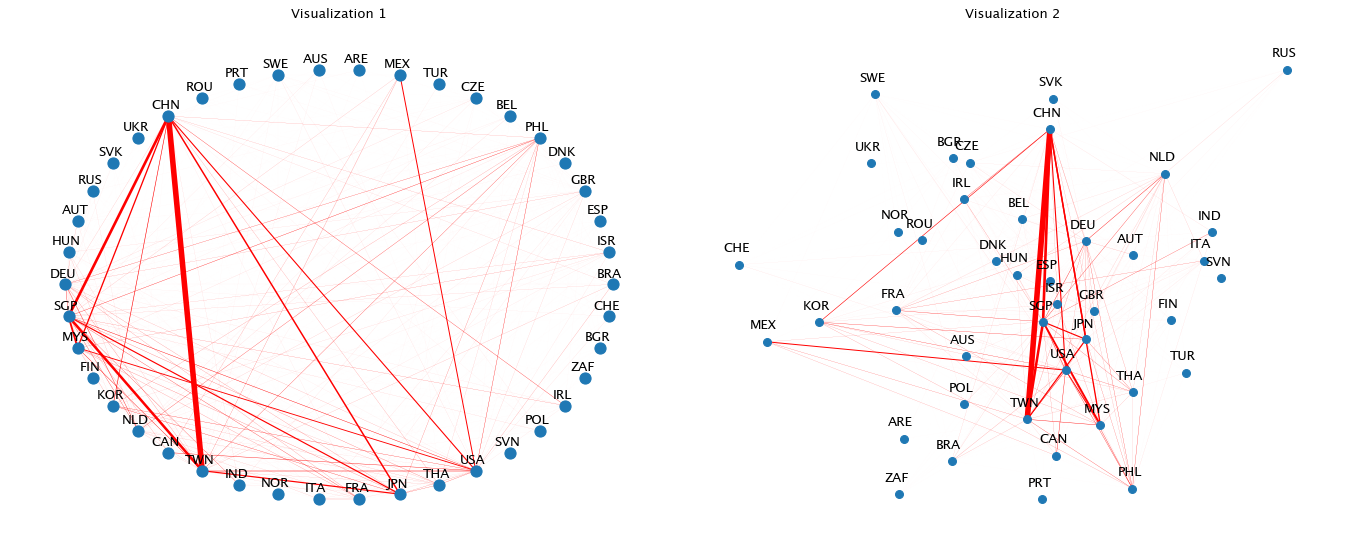

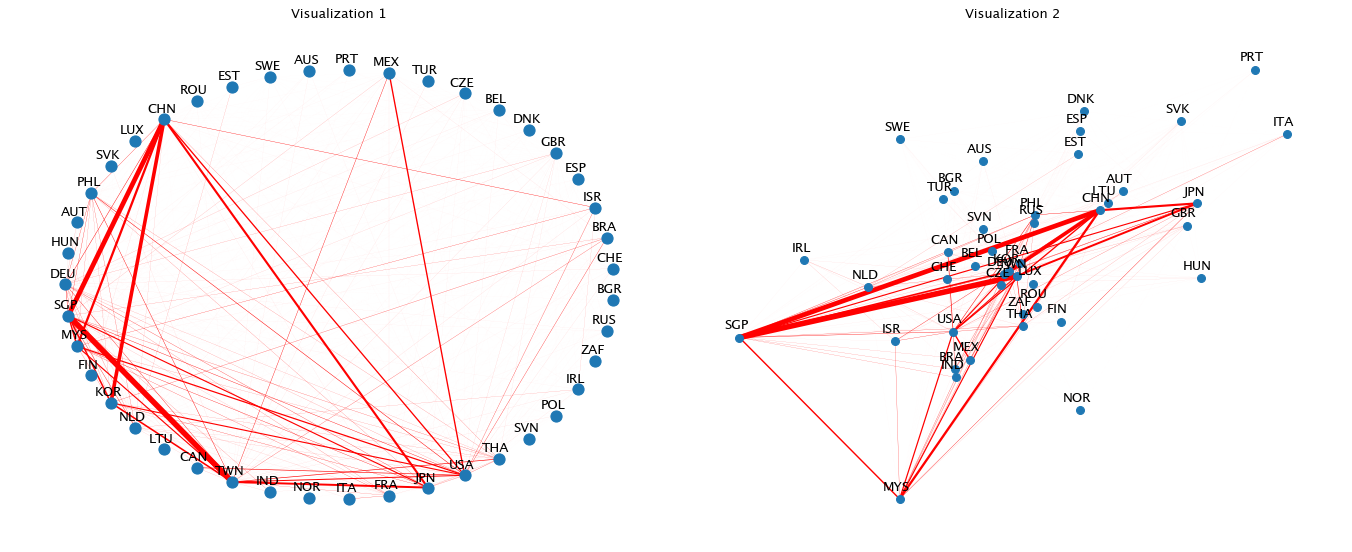

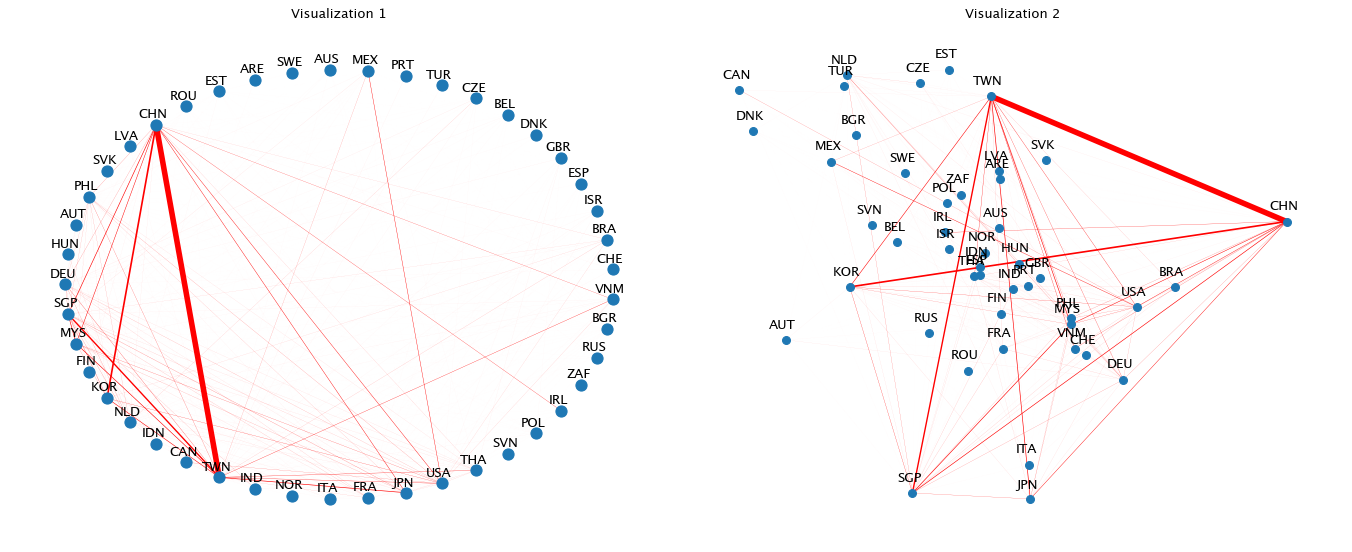

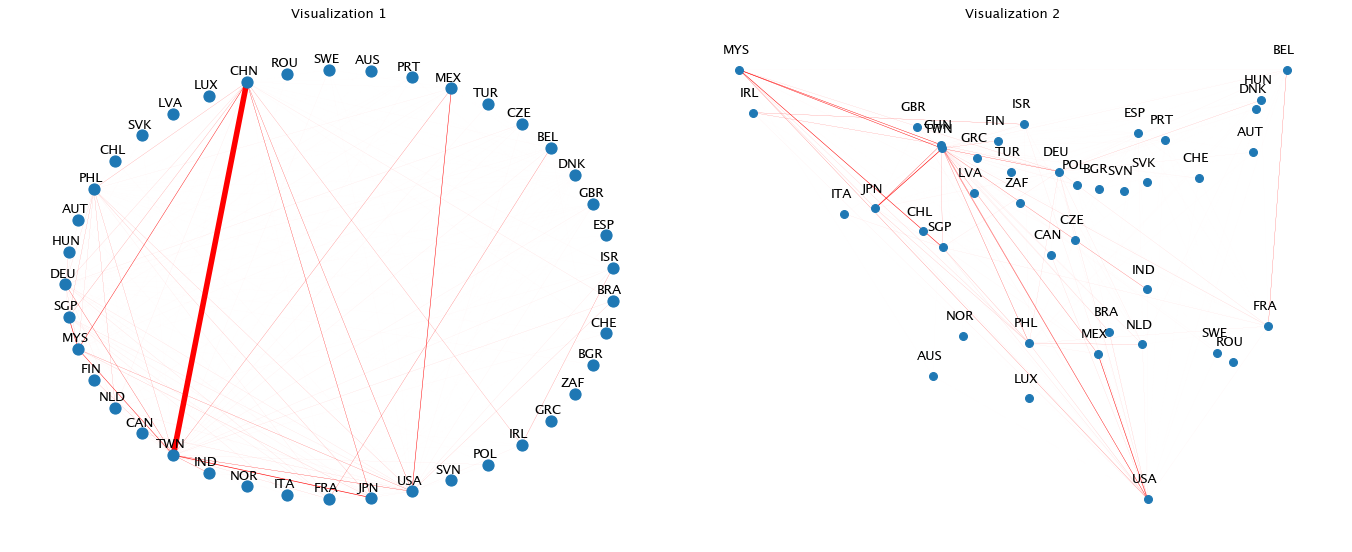

In [118]:

# Apply to chosen periods
chosen_periods = ['2010-01-01', '2014-08-01', '2019-01-01', '2023-08-01']

for period in chosen_periods:
    # Filter data for the specific period
    original_data = df_trade[df_trade['Period'] == period]

    # Create and filter network for the period
    G, nodes_notimp, nodes_imp = identify_node_importance_for_period(df_trade, period)


    # Plot the network after removal
    plot_network(G)


### Construct Structure properties matrix

In [119]:

# Initialize lists to store the number of nodes and edges
num_nodes_list = []
num_edges_list = []
density_list = []
avg_clustering_list = []
assortativity_list = []
avg_shortest_path_list = []

# Iterate through the network sets
for subset_name, subset_graph in network_sets.items():
    # Extract the period from the subset name
    period = subset_name.split('_')[1]
    period_dt = pd.to_datetime(period)
    
    # Calculate the metrics and append to the lists
    num_nodes_list.append((period_dt, subset_graph.number_of_nodes()))
    num_edges_list.append((period_dt, subset_graph.number_of_edges()))
    density_list.append((period_dt, nx.density(subset_graph)))
    avg_clustering_list.append((period_dt, nx.average_clustering(subset_graph)))
    assortativity_list.append((period_dt, nx.degree_assortativity_coefficient(subset_graph)))
    
    # Calculate average shortest path length if the graph is connected
    if nx.is_connected(subset_graph):
        avg_shortest_path_list.append((period_dt, nx.average_shortest_path_length(subset_graph)))
    else:
        avg_shortest_path_list.append((period_dt, None))  # Mark as None for disconnected graphs

# Sort the lists based on the period
num_nodes_list.sort(key=lambda x: x[0])
num_edges_list.sort(key=lambda x: x[0])
density_list.sort(key=lambda x: x[0])
avg_clustering_list.sort(key=lambda x: x[0])
assortativity_list.sort(key=lambda x: x[0])
avg_shortest_path_list.sort(key=lambda x: x[0])


In [123]:

# Create a DataFrame
properties = pd.DataFrame({
    'Period': [item[0] for item in num_nodes_list], 
    'num_nodes': [item[1] for item in num_nodes_list],
    'num_edges': [item[1] for item in num_edges_list],
    'density': [item[1] for item in density_list],
    'clustering': [item[1] for item in avg_clustering_list],
    'assortativity': [item[1] for item in assortativity_list],
    'shortest_path': [item[1] for item in avg_shortest_path_list]
})

# Save to csv
# properties.to_csv('data/processed/properties.csv',index=False)

# Display the first few rows and a concise summary of the DataFrame
print(properties.info())
# Get the descriptive table for properties
print(properties.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Period         164 non-null    datetime64[ns]
 1   num_nodes      164 non-null    int64         
 2   num_edges      164 non-null    int64         
 3   density        164 non-null    float64       
 4   clustering     164 non-null    float64       
 5   assortativity  164 non-null    float64       
 6   shortest_path  163 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 9.1 KB
None
                              Period   num_nodes    num_edges     density  \
count                            164  164.000000   164.000000  164.000000   
mean   2016-10-15 19:19:01.463414528  174.969512  2043.890244    0.134320   
min              2010-01-01 00:00:00  166.000000  1804.000000    0.120104   
25%              2013-05-24 06:00:00  172.000000  1957.

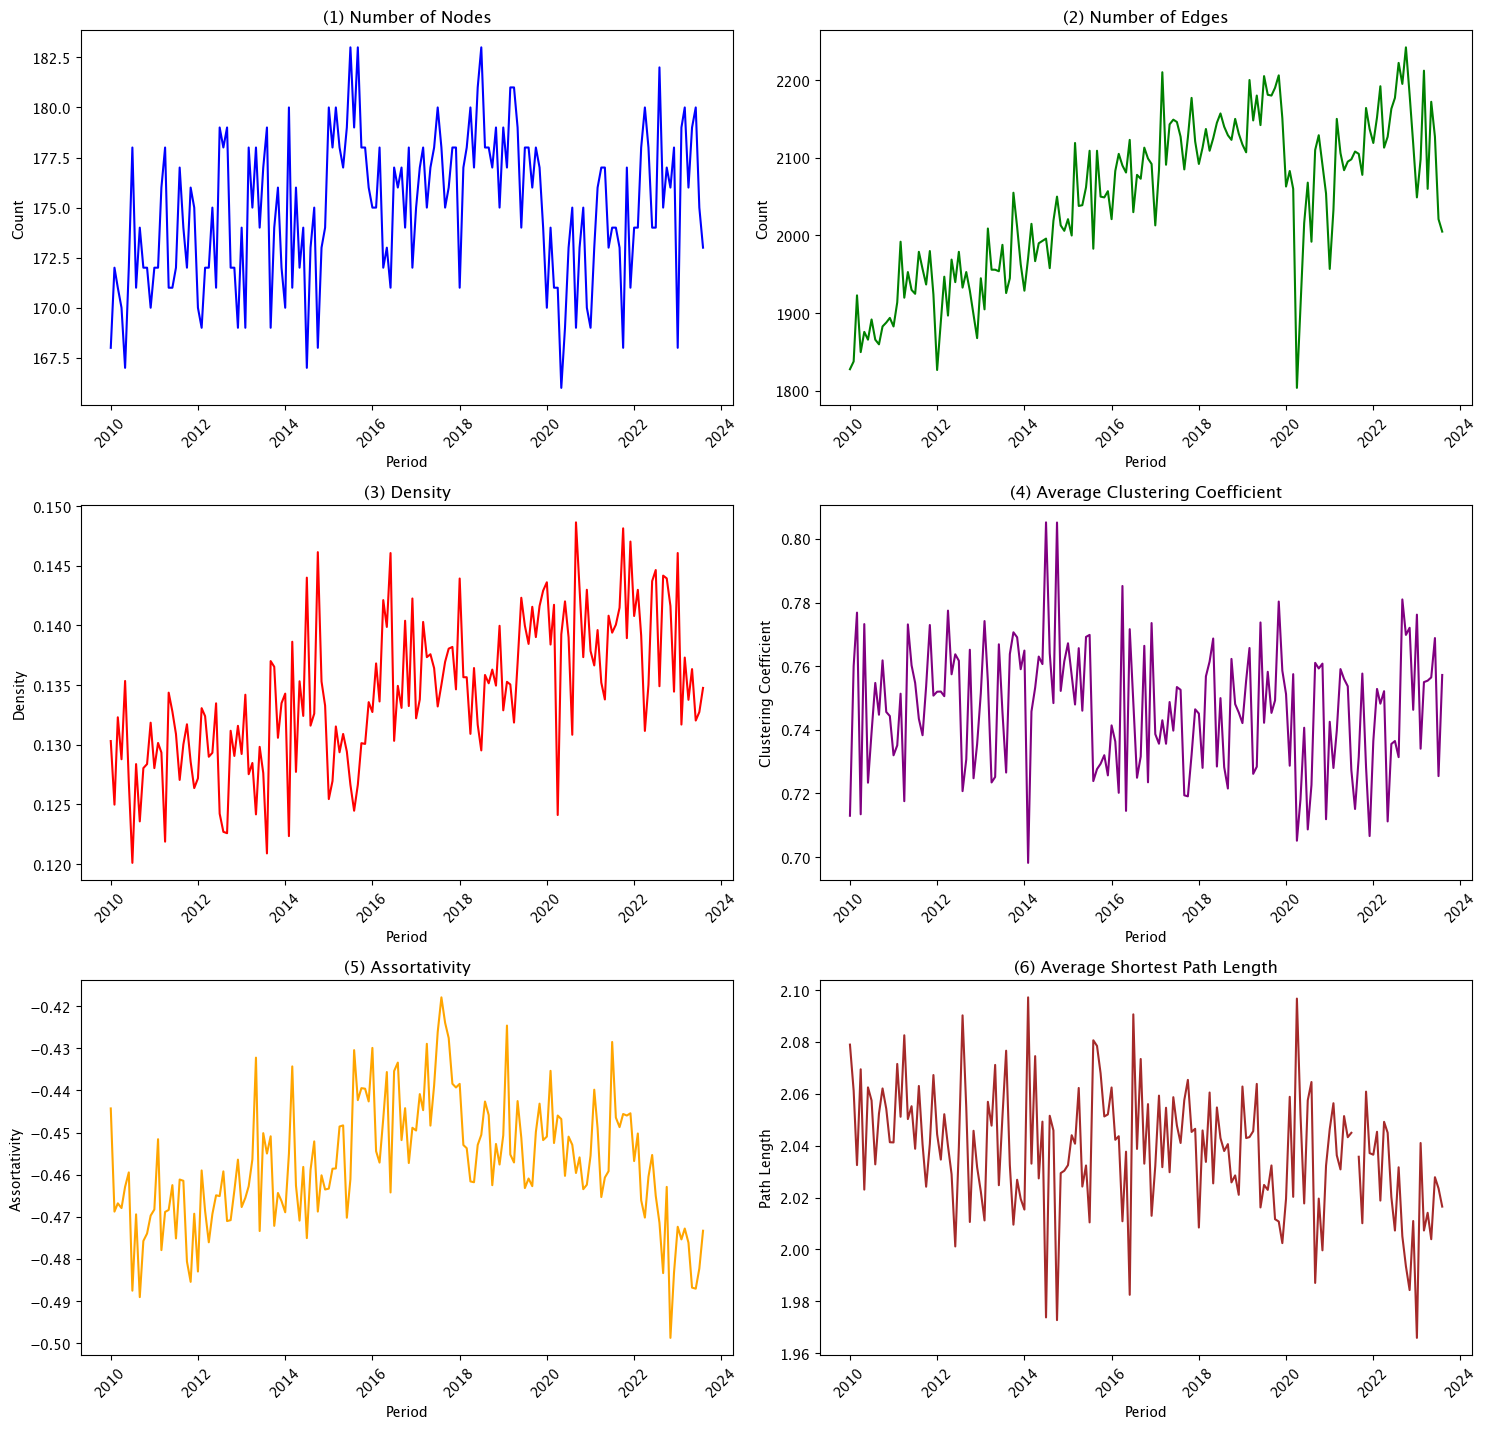

In [124]:

# Plot each column
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
# fig.suptitle('Network Properties Over Time')

# Titles and labels for each subplot
titles = ['(1) Number of Nodes', '(2) Number of Edges', '(3) Density', '(4) Average Clustering Coefficient', '(5) Assortativity', '(6) Average Shortest Path Length']
ylabels = ['Count', 'Count', 'Density', 'Clustering Coefficient', 'Assortativity', 'Path Length']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

# Plot properties
for i, ax in enumerate(axs.flat):
    ax.plot(properties['Period'], properties[properties.columns[i + 1]], label=titles[i], color=colors[i])
    ax.set_title(titles[i])
    ax.set_xlabel('Period')
    ax.set_ylabel(ylabels[i])
    ax.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plots
plt.show()
